# Regression analysis with SVD decomposition

In [1]:
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal
from numpy.linalg import cholesky, svd

import pytest

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Linear model is $$E[Y|A,B]=E[Y]+a(A-E[A])+b(B-E[B])$$

In [3]:
Sa = 3
Sb = 5
def model(a, b):
    return Sa * a + Sb * b

In [4]:
Va = 2
Vb = 1.5
Cab = 0.4 * np.sqrt(Va) * np.sqrt(Vb)

In [5]:
C_AB = np.array([
    [Va, Cab],
    [Cab, Vb],
])

Bivariate probelms with covariance matrix
$$
C_{AB}=\begin{bmatrix}
Var(A) & Cov(A,B)\\
Cov(A,B) & Var(B)
\end{bmatrix}
$$

For a covariance matrix, the Cholesky decomposition and SVD (equal to eigenvalue decomposition in this case) are related by the following equation:

$$
C_{AB}=L  L^T = U S V^T
$$

Also, $U=V$. Diagonal matrix $S$ contains the eigenvalues of the $C_{AB}$.

In [6]:
L = cholesky(C_AB)
np.testing.assert_array_almost_equal(C_AB, L @ L.T)

In [7]:
U, S, V = svd(C_AB)
np.testing.assert_array_almost_equal(U, V.T)
np.testing.assert_array_almost_equal(C_AB, U @ np.diag(S) @ U.T)

With a change of notation we rewrite
$$
S=\begin{bmatrix}
\lambda_{A^*}^2 & 0\\
0 & \lambda_{B^*}^2
\end{bmatrix} =
\begin{bmatrix}
\lambda_{A^*} & 0\\
0 & \lambda_{B^*}
\end{bmatrix}
\begin{bmatrix}
\lambda_{A^*} & 0\\
0 & \lambda_{B^*}
\end{bmatrix}^T =
\left(\Lambda^{1/2}\right)\left(\Lambda^{1/2}\right)^T
$$
Then: $$C_{AB}=\left(U\Lambda^{1/2}\right)\left(U \Lambda^{1/2}\right)^T$$

In [8]:
Lambda12 = np.diag(np.sqrt(S))
np.testing.assert_array_almost_equal(C_AB, U @ Lambda12 @ Lambda12.T @ U.T)

But it seems that $$ L\neq U\Lambda^{1/2}$$

In [9]:
with pytest.raises(Exception):
    np.testing.assert_array_almost_equal(L, U @ Lambda12)

From the above definitions we derive that: $$
\begin{bmatrix}
A \\
B
\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix},
C_{AB}\right)
$$

Let's define to i.i.d variables $A^*$ and $B^*$, so that

$$
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix} \sim \mathcal{N}\left(0,I\right)
$$

where $I$ is the identity matrix and $0$ is a zero vector.
Then $\left(A^*,B^*\right)$ and $\left(A,B\right)$ can be related as

$$
\begin{bmatrix}
A \\
B
\end{bmatrix}=\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix} + U\Lambda^{1/2} 
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}
$$

since

$$
E\begin{bmatrix}
A \\
B
\end{bmatrix}=\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix} + E\left[U\Lambda^{1/2} 
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}\right]=\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix} + U\Lambda^{1/2} 
E\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}=\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix} + U\Lambda^{1/2} 
E\begin{bmatrix}
0 \\
0
\end{bmatrix}=\begin{bmatrix}
E[A] \\
E[B]
\end{bmatrix}
$$

and
$$
E\left[
\begin{bmatrix}
A \\
B
\end{bmatrix}
\begin{bmatrix}
A \\
B
\end{bmatrix}^T
\right]  =
E\left[\left(
U\Lambda^{1/2} 
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}\right)
\left(
U\Lambda^{1/2} 
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}\right)^T
\right]  =
\left(U\Lambda^{1/2}\right)
E\left[\left(
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}\right)
\left(
\begin{bmatrix}
A^* \\
B^*
\end{bmatrix}\right)^T
\right]
\left(U\Lambda^{1/2}\right)^T = \left(U\Lambda^{1/2}\right)I\left(U\Lambda^{1/2}\right)^T=\left(U\Lambda^{1/2}\right)\left(U\Lambda^{1/2}\right)^T=C_{AB}
$$

Let's rewrite a linear model in terms of $A^*$ and $B^*$, as $$E[Y|A^*,B^*]=E[Y]+a^* A^* + b^* B^*$$

If the above relations are true, the equality $E[Y|A^*,B^*]=E[Y|A,B]$ holds when
$$
\left(U\Lambda^{1/2}\right)^T
\begin{bmatrix}
a \\
b
\end{bmatrix} = 
\begin{bmatrix}
a^* \\
b^*
\end{bmatrix}
$$

Then, since $A^*$ and $B^*$ are independent we can calculate $a^*$ and $b^*$ as $$
\begin{bmatrix}
a^* \\
b^*
\end{bmatrix} = 
\begin{bmatrix}
\frac{Cov(E[Y|A^*,B^*], A^*)}{Var(A^*)}\\
\frac{Cov(E[Y|A^*,B^*], B^*)}{Var(VB^*)}
\end{bmatrix} = 
\begin{bmatrix}
Cov(E[Y|A^*,B^*], A^*)\\
Cov(E[Y|A^*,B^*], B^*)
\end{bmatrix}
$$

Then, $a$ and $b$ are $$
\begin{bmatrix}
a \\
b
\end{bmatrix} = 
\left(\left(U\Lambda^{1/2}\right)^T\right)^{-1}
\begin{bmatrix}
Cov(E[Y|A^*,B^*], A^*)\\
Cov(E[Y|A^*,B^*], B^*)
\end{bmatrix}
$$

In [10]:
N = 100000

In [11]:
# non correlated, standardized sample
X_ = multivariate_normal(mean=[0, 0], cov=np.eye(2), size=N)

# correlated sample
X = (U @ Lambda12 @ X_.T).T

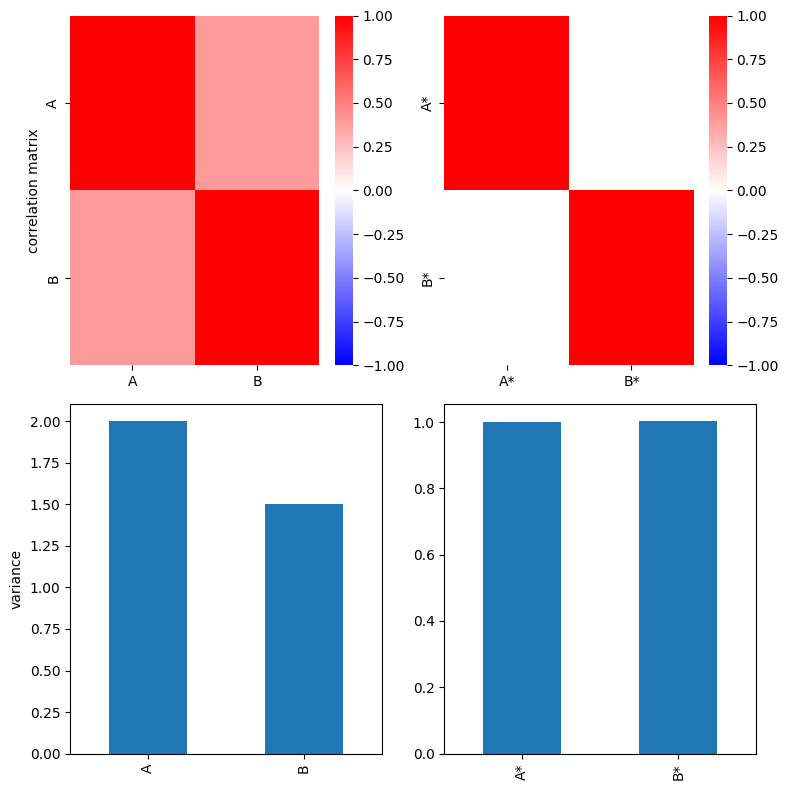

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(X.T), index=["A", "B"], columns=["A", "B"]), ax=axs[0,0], cmap="bwr", vmin=-1, vmax=1)
sns.heatmap(pd.DataFrame(np.corrcoef(X_.T), index=["A*", "B*"], columns=["A*", "B*"]), ax=axs[0,1], cmap="bwr", vmin=-1, vmax=1)
pd.Series(np.var(X, axis=0), index=["A", "B"]).plot(kind="bar", ax=axs[1,0])
pd.Series(np.var(X_, axis=0), index=["A*", "B*"]).plot(kind="bar", ax=axs[1,1])

axs[0,0].set_ylabel("correlation matrix")
axs[1,0].set_ylabel("variance")
fig.tight_layout()

In [13]:
Y = np.array([model(*row) for row in X])

In [14]:
Z = np.array([np.cov(Y, row)[0, 1] for row in X_.T])

In [15]:
np.linalg.inv((U @ Lambda12).T) @ Z

array([2.99828074, 5.00441521])

## Case 1: dependence on the variance size

In [16]:
def foo(n):
    N = 10000
    Va = 2 * n
    Vb = 1.5 * n
    Cab = 0 * np.sqrt(Va) * np.sqrt(Vb)
    C_AB = np.array([
        [Va, Cab],
        [Cab, Vb],
    ])
    X_ = multivariate_normal(mean=[0, 0], cov=np.eye(2), size=N)
    X = (U @ Lambda12 @ X_.T).T
    Y = np.array([model(*row) for row in X])
    Z = np.array([np.cov(Y, row)[0, 1] for row in X_.T])
    return np.linalg.inv((U @ Lambda12).T) @ Z

In [17]:
df = pd.DataFrame({n: [*foo(n)] for n in np.linspace(0.1, 7, 100)}).T
df.columns = ["A", "B"]

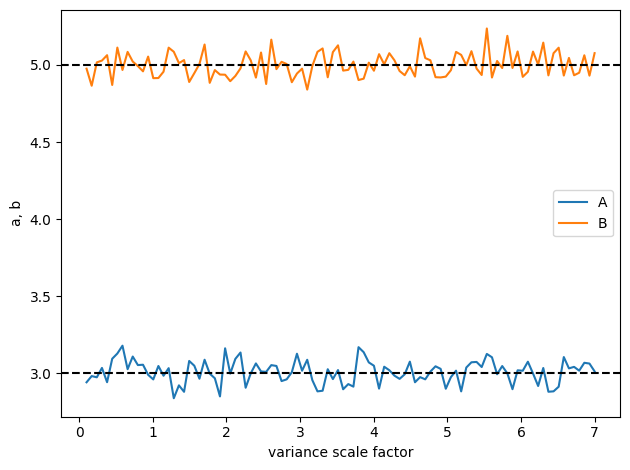

In [18]:
fig, ax = plt.subplots()
df.plot(ax=ax)
ax.set(
    xlabel="variance scale factor",
    ylabel="a, b",
)
ax.axhline(Sa, ls="--", color="k")
ax.axhline(Sb, ls="--", color="k")
fig.tight_layout();